## Autoreload

In [ ]:
%load_ext autoreload
%autoreload 2

## Libraries

In [ ]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pywt
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import detrend, butter, filtfilt
import ipywidgets as widgets
from IPython.display import display

## Parameters

### Accceleration data


**Generate acceleration data**

In [ ]:
def generate_vibration_signal_dataframe(
    total_time: float,
    sampling_rate: float,
    frequency_funcs: list,
    amplitude_funcs: list,
    noise_amplitude: float,
    direction: str,
) -> pd.DataFrame:
    """
    Generates a synthetic vibration signal with time-varying frequencies and returns it as a DataFrame.

    Args:
        total_time: Total duration of the signal (in seconds).
        sampling_rate: Sampling rate (in Hz).
        frequency_funcs: List of functions describing how frequencies vary over time.
        amplitude_funcs: List of functions describing how amplitudes vary over time.
        noise_amplitude: Amplitude of random noise added to the signal.
        direction: Direction of the vibration signal.

    Returns:
        DataFrame with columns 'Time' and '{direction} Acceleration'.
    """
    # Generate the time array
    t = np.linspace(0, total_time, int(total_time * sampling_rate), endpoint=False)

    # Initialize the signal with zeros
    acceleration = np.zeros_like(t)

    # Add vibration components with time-varying frequencies and amplitudes
    for freq_func, amp_func in zip(frequency_funcs, amplitude_funcs):
        # Calculate the instantaneous frequency and amplitude at each time point
        instantaneous_frequencies = freq_func(t)
        instantaneous_amplitudes = amp_func(t)
        # Generate the sinusoidal component with time-varying frequency and amplitude
        acceleration += instantaneous_amplitudes * np.sin(
            2 * np.pi * instantaneous_frequencies * t
        )

    # Add random noise
    acceleration += noise_amplitude * np.random.normal(size=len(t))

    # Create a DataFrame with time and signal
    df = pd.DataFrame(
        {
            "Time": t,
            f"{direction} Acceleration": acceleration,
        }
    )

    return df

In [ ]:
total_time = 100.0
sampling_rate = 200.0

frequency_funcs: list = [lambda t: 10.0 + 0.0 * t, lambda t: 20.0 + 0. * t, lambda t: 40. + 0.0 * t]
amplitude_funcs: list = [lambda t: 5.0 - 0.005 * t, lambda t: 5.0 + 0.00 * t, lambda t: 5. - 0.00 * t]


direction ='X'
corrected = 'X Baseline Corrected'
filtered = 'X Baseline Corrected Filtered'

noise_amplitude = 0.5
threshold_percentage = 10

In [ ]:
df = generate_vibration_signal_dataframe(total_time, sampling_rate, frequency_funcs, amplitude_funcs, noise_amplitude, direction)

In [ ]:
df

,Time,X Acceleration
0,0.000,0.034003
1,0.005,9.162686
2,0.010,10.700133
3,0.015,5.836344
4,0.020,2.928276
...,...,...
19995,99.975,-4.685535
19996,99.980,-2.472411
19997,99.985,-5.539980
19998,99.990,-10.189491


In [ ]:
def plot_acceleration(df: pd.DataFrame, direction: str, color: str = "red"):
    """
    Plots the acceleration signal from a DataFrame.

    Args:
        df: DataFrame containing 'Time' and '{direction} Acceleration' columns.
        direction: Direction of the acceleration signal to plot.
        color: Color of the plot line (default is 'red').

    Returns:
        None
    """
    plt.figure(figsize=(15, 6))
    plt.plot(
        df["Time"],
        df[f"{direction} Acceleration"],
        color=color,
        linestyle="-",
        label=direction,
    )

    plt.title(f'{direction} Acceleration')
    plt.xlabel("Time (s)")
    plt.ylabel(r"Acceleration ($m/s^{2}$)")
    plt.legend()
    plt.show()

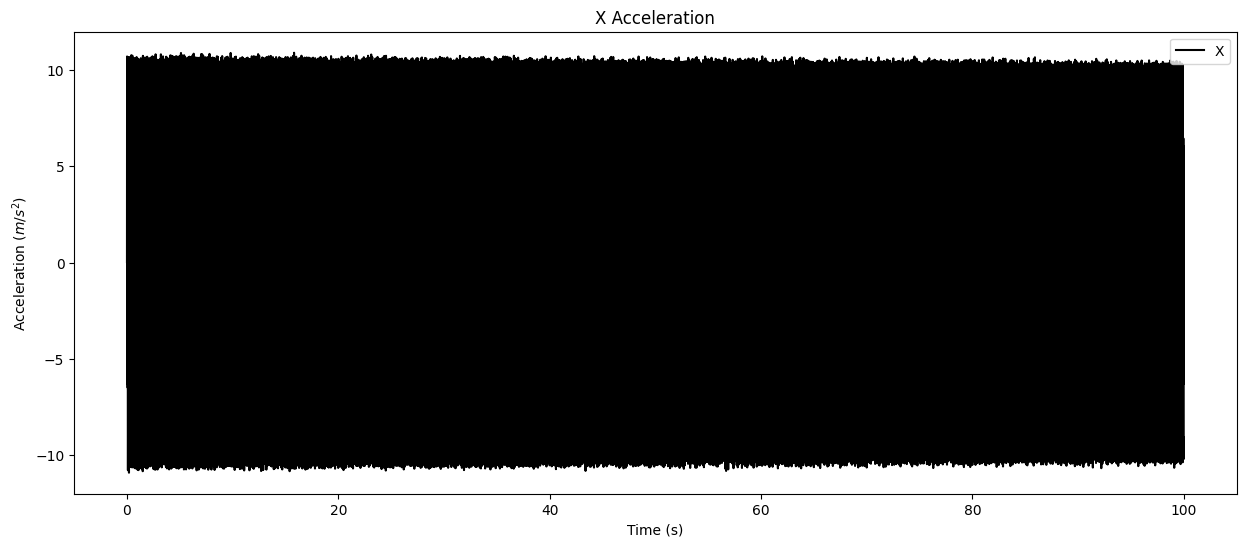

In [ ]:
plot_acceleration(df, direction, color='k')

## FFT analysis

In [ ]:
def plot_normalized_fft(df_fft: pd.DataFrame, direction: str, color: str = "red") -> None:
    """
    Plots the normalized FFT magnitude spectrum from a DataFrame.

    Args:
        df_fft: DataFrame containing '{direction} Frequency' and '{direction} Magnitude' columns.
        direction: The direction of the vibration (e.g., 'X', 'Y', 'Z').
        color: Color of the plot line (default is 'red').

    Returns:
        None

    Assumptions:
        - 'df_fft' contains '{direction} Frequency' and '{direction} Magnitude' columns.
    """
    frequencies = df_fft[f'Frequency']
    magnitudes = df_fft[f'{direction} Magnitude']

    # Plotting the FFT Magnitude Spectrum
    plt.figure(figsize=(10, 6))
    # Plot only the positive frequencies
    plt.plot(
        frequencies[:],
        magnitudes[:] / max(magnitudes[:]),
        color=color,
        linestyle="-",
        label=direction,
    )
    plt.title("FFT Normalized Magnitude Spectrum ")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

In [ ]:
def plot_fft(df_fft: pd.DataFrame, direction: str) -> None:
    """
    Plots the FFT magnitude spectrum from a DataFrame.

    Args:
        df_fft: DataFrame containing '{direction} Frequency' and '{direction} Magnitude' columns.
        direction: The direction of the vibration (e.g., 'X', 'Y', 'Z').

    Returns:
        None

    Assumptions:
        - 'df_fft' contains '{direction} Frequency' and '{direction} Magnitude' columns.
    """
    frequencies = df_fft[f"Frequency"]
    magnitudes = df_fft[f"{direction} Magnitude"]

    # Plotting the FFT Magnitude Spectrum
    plt.figure(figsize=(10, 6))
    # Plot only the positive frequencies
    plt.plot(frequencies[:], magnitudes[:])
    plt.title("FFT Magnitude Spectrum ")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.show()

In [ ]:
def calculate_fft(df: pd.DataFrame, direction: str) -> pd.DataFrame:
    """
    Calculates the FFT of a single acceleration data column and returns a DataFrame with the results.

    Args:
        df: DataFrame containing 'Time' and '{direction} Acceleration' columns.
        direction: The direction of the vibration (e.g., 'X', 'Y', 'Z').

    Returns:
        DataFrame containing the FFT results with '{direction} Frequency' and '{direction} Magnitude' columns.

    Assumptions:
        - 'df' contains 'Time' and '{direction} Acceleration' columns.
        - Time is uniformly sampled.
    """
    n = len(df[f"{direction} Acceleration"])
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step

    accelerations = np.fft.fft(df[f"{direction} Acceleration"])
    frequencies = np.fft.fftfreq(n, 1 / sampling_rate)
    magnitudes = np.abs(accelerations)

    # Create a DataFrame with frequencies and magnitudes (only positive frequencies)
    df_fft = pd.DataFrame(
        {
            f'Frequency': frequencies[: n // 2],
            f'{direction} Magnitude': magnitudes[: n // 2],
        }
    )
    return df_fft

In [ ]:
def preprocess_data(df: pd.DataFrame, direction: str, direction_corrected: str) -> pd.DataFrame:
    """
    Preprocesses the data by removing outliers and detrending the acceleration signal.

    Args:
        df: DataFrame containing 'Time' and '{direction} Acceleration' columns.
        direction: The direction of the vibration (e.g., 'X', 'Y', 'Z').

    Returns:
        DataFrame with outliers removed and the acceleration signal detrended.

    Assumptions:
        - 'df' contains 'Time' and '{direction} Acceleration' columns.
    """
    # Remove outliers (values beyond 3 standard deviations)
    mean = df[f'{direction} Acceleration'].mean()
    std = df[f'{direction} Acceleration'].std()
    df[f'{direction} Acceleration'] = np.where(
        np.abs(df[f'{direction} Acceleration'] - mean) <= 3 * std,
        df[f'{direction} Acceleration'],
        mean,
    )

    # Detrend the data
    df["Time"] = df["Time"]
    df[f'{direction_corrected} Acceleration'] = detrend(df[f'{direction} Acceleration'])

    return df

In [ ]:
df = preprocess_data(df, direction, direction_corrected)

In [ ]:
df_fft = calculate_fft(df, direction_corrected)

In [ ]:
df_fft

,Frequency,X Baseline Corrected Magnitude
0,0.00,2.390976e-12
1,0.01,5.505399e+01
2,0.02,2.293520e+01
3,0.03,7.982181e+00
4,0.04,2.554477e+01
...,...,...
9995,99.95,3.140942e+00
9996,99.96,2.453364e+01
9997,99.97,1.237651e+01
9998,99.98,1.141498e+01


## Filter with FFT and iFFT

In [ ]:
def filter_with_fft(
    df: pd.DataFrame, direction: str, threshold_percentage: float
) -> pd.Series:
    """
    Filters FFT output by zeroing frequencies with magnitudes below a threshold and reconstructs the filtered signal.

    Args:
        df: DataFrame containing 'Time' and '{direction}' Acceleration columns.
        direction: The direction of the acceleration data to filter (default: 'X Baseline Corrected').
        threshold_percentage: Percentage of the maximum magnitude below which frequencies are filtered out (default: 5).

    Returns:
        A Pandas Series with filtered acceleration data.

    Assumptions:
        - 'df' contains 'Time' and '{direction} Acceleration' columns.
        - Time data is uniformly sampled.
        - 'threshold_percentage' is a float between 0 and 100.
    """
    # Input validation
    if not 0 <= threshold_percentage <= 100:
        raise ValueError("threshold_percentage must be between 0 and 100.")

    n = len(df[direction])
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step

    fft_data = fft(df[direction])
    magnitude = np.abs(fft_data)
    threshold = np.max(magnitude) * threshold_percentage / 100

    fft_filtered = fft_data.copy()
    fft_filtered[magnitude < threshold] = 0

    df[f'{direction} Filtered Acceleration '] = ifft(fft_filtered).real

    return df

In [ ]:
df

,Time,X Acceleration,X Baseline Corrected Acceleration
0,0.000,0.034003,0.026151
1,0.005,9.162686,9.154834
2,0.010,10.700133,10.692282
3,0.015,5.836344,5.828493
4,0.020,2.928276,2.920426
...,...,...,...
19995,99.975,-4.685535,-4.680107
19996,99.980,-2.472411,-2.466982
19997,99.985,-5.539980,-5.534550
19998,99.990,-10.189491,-10.184060


In [ ]:
def fft_filter(df: pd.DataFrame, sampling_rate: float=100, threshold_percentage: float=10, direction:str='X') -> pd.DataFrame:
    """
    Calculates and combines FFT results for X, Y, and Z acceleration data into a single DataFrame.

    Args:
        df: DataFrame with 'X Acceleration', 'Y Acceleration', and 'Z Acceleration' columns.
        sampling_rate: Sampling rate of the acceleration data.

    Returns:
        A Pandas DataFrame with combined FFT results for all three axes, including 'Frequency', 'Magnitude', and 'Axis' columns.

    Assumptions:
        - 'df' contains 'X Acceleration', 'Y Acceleration', and 'Z Acceleration' columns.
        - Acceleration data is in numerical format.
        - 'sampling_rate' is a positive numerical value.
    """
    df[f'{direction} Filtered Acceleration'] = pd.DataFrame(filter_with_fft(df[f'{direction} Acceleration'], sampling_rate, threshold_percentage))

    return df

In [ ]:
def butter_bandpass_filter(df: pd.DataFrame, lowcut: int=3, highcut: int=40, fs: int=100, order: int=4, direction: str='X'):
    """Aplica un filtro pasa-banda de Butterworth."""
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, df[f'{direction} Acceleration'])

In [ ]:
sampling_rate

200.0

In [ ]:
df[f'{direction_filtered} Acceleration'] = butter_bandpass_filter(df, lowcut = 0.3, highcut = 99, fs=sampling_rate, direction=direction_corrected)
df_fft = calculate_fft(df, direction_filtered)

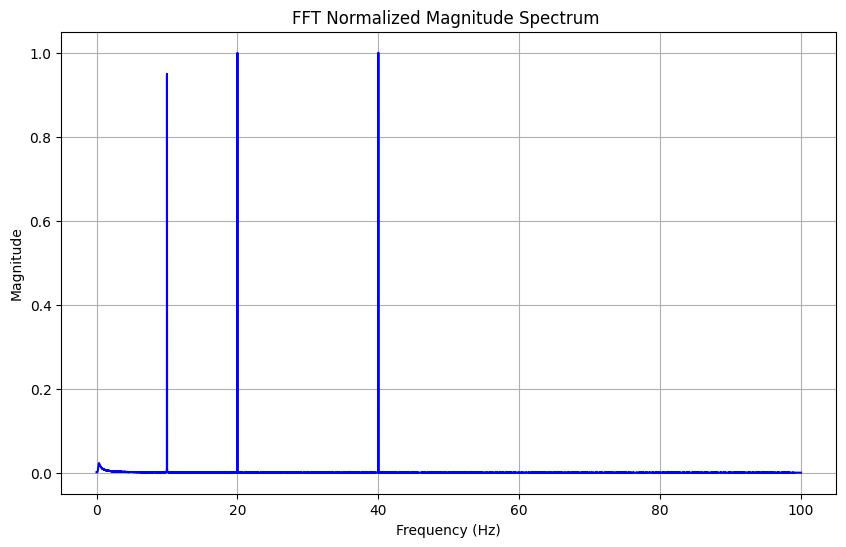

In [ ]:
plot_normalized_fft(df_fft, direction_filtered, 'blue')

In [ ]:
df

,Time,X Acceleration,X Baseline Corrected Acceleration,X Baseline Corrected Filtered Acceleration
0,0.000,0.034003,0.026151,0.975118
1,0.005,9.162686,9.154834,10.062208
2,0.010,10.700133,10.692282,11.627765
3,0.015,5.836344,5.828493,6.723395
4,0.020,2.928276,2.920426,3.842412
...,...,...,...,...
19995,99.975,-4.685535,-4.680107,6.992812
19996,99.980,-2.472411,-2.466982,9.551607
19997,99.985,-5.539980,-5.534550,6.755059
19998,99.990,-10.189491,-10.184060,2.466338


In [ ]:
df_fft_filtered = calculate_fft(df, direction)

In [ ]:
def cwt_analysis(
    df: pd.DataFrame,
    direction: str,
    wavelet: str = 'cmor1.5-1.0',
    min_scale: int = 1,
    max_scale: int = 32,
):  # -> Tuple[np.ndarray, np.ndarray, np.ndarray, float, float, float, float]: #no entiendo porque da error
    """
    Performs Continuous Wavelet Transform (CWT) analysis on acceleration data.

    Args:
        df: DataFrame containing 'Time' and '{direction} Acceleration' columns.
        direction: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        wavelet: Wavelet function to use (default: 'morl').
        min_scale: Minimum scale for CWT (default: 1).
        max_scale: Maximum scale for CWT (default: 100).

    Returns:
        A tuple containing:
            - spectrum: Magnitude spectrum of the CWT coefficients.
            - frequencies: Frequencies corresponding to the scales.
            - time_min: Minimum time value in the DataFrame.
            - time_max: Maximum time value in the DataFrame.
            - freq_min: Minimum frequency value.
            - freq_max: Maximum frequency value.

    Assumptions:
        - 'df' contains 'Time' and '{direction} Acceleration' columns.
        - 'Time' data is uniformly sampled.
        - 'direction' is a valid column in df
    """
    # Validations
    if f"{direction} Acceleration" not in df.columns:
        raise ValueError(f"{direction} Acceleration is not found in DataFrame.")
    if "Time" not in df.columns:
        raise ValueError("The DataFrame must contain a 'Time' column.")

    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step
    nyquist_freq = sampling_rate / 2

    scales = np.arange(min_scale, max_scale)
    coefficients, frequencies = pywt.cwt(
        df[f"{direction} Acceleration"], scales, wavelet, time_step
    )

    # Magnitude spectrum
    spectrum = np.abs(coefficients)

    return (spectrum, frequencies)

In [ ]:
wavelet ='morl'
min_scale = 1
max_scale = min_scale / 0.8125 * 2**6

In [ ]:
spectrum, frequencies = cwt_analysis(df, direction, wavelet, min_scale, max_scale)

In [ ]:
def analyze_wavelet_spectrum(df: pd.DataFrame, direction: str, wavelet: str='cmor1.5-1.0',
                             min_scale: float=0.3, max_scale: float=0.2) -> None:
    """
    Applies Continuous Wavelet Transform (CWT) to filtered acceleration data,
    calculates the average spectrum, and visualizes the time-frequency-magnitude spectrum.

    Args:
        df: DataFrame with 'Time' and at least one acceleration column.
        acceleration_column: Name of the acceleration column to analyze.
        wavelet: Wavelet function to use.
        min_scale: Minimum scale for the wavelet transform.
        max_scale: Maximum scale for the wavelet transform.

    Returns:
        None (displays the interactive 3D plot).
    """
   
    spectrum, frequencies = cwt_analysis(df, direction, wavelet, min_scale, max_scale)
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step
    nyquist_freq = sampling_rate / 2
            # Minimum and maximum values for sliders
    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), nyquist_freq

    def plot_wavelet_spectrum(elevation=0, rotation=0, label_size=10,
                              min_time=time_min, max_time=time_max, 
                              min_frequency=freq_min, max_frequency=freq_max):
        # Filtrar el rango de tiempo y frecuencia
        mask_x = (df['Time'] >= min_time) & (df['Time'] <= max_time)
        mask_y = (frequencies >= min_frequency) & (frequencies <= max_frequency)

        time_filtered = df['Time'][mask_x].values
        frequencies_filtered = frequencies[mask_y]
        spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

        # Crear la malla para el gráfico
        X, Y = np.meshgrid(time_filtered, frequencies_filtered)

        # Verificar dimensiones
        if X.shape != spectrum_filtered.shape:
            print(f"Shape mismatch: X{X.shape}, Y{Y.shape}, Z{spectrum_filtered.shape}")
            return

        # Crear la figura 3D
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, spectrum_filtered, cmap='viridis')
        # ax.plot_surface(X, Y, spectrum_filtered, cmap='plasma')

        ax.set_xlabel('Time (s)', fontsize=label_size)
        ax.set_ylabel('Frequency (Hz)', fontsize=label_size)
        ax.set_zlabel('Magnitude', fontsize=label_size)
        ax.set_title('Time - Frequency - Magnitude Wavelet Spectrum', fontsize=label_size)
        ax.view_init(elev=elevation, azim=rotation)
        plt.show()

    # Crear controles interactivos
    widgets.interact(
        plot_wavelet_spectrum,
        elevation=(0, 360, 10),
        rotation=(0, 360, 10),
        label_size=(6, 32, 2),
        min_time=(time_min, time_max, (time_max - time_min) / 100),
        max_time=(time_min, time_max, (time_max - time_min) / 100),
        min_frecuency=(freq_min, freq_max, (freq_max - freq_min) / 50),
        max_frequency=(freq_min, freq_max, (freq_max - freq_min) / 50)
    ) 

In [ ]:
df

,Time,X Acceleration,X Baseline Corrected Acceleration,X Baseline Corrected Filtered Acceleration
0,0.000,0.034003,0.026151,0.975118
1,0.005,9.162686,9.154834,10.062208
2,0.010,10.700133,10.692282,11.627765
3,0.015,5.836344,5.828493,6.723395
4,0.020,2.928276,2.920426,3.842412
...,...,...,...,...
19995,99.975,-4.685535,-4.680107,6.992812
19996,99.980,-2.472411,-2.466982,9.551607
19997,99.985,-5.539980,-5.534550,6.755059
19998,99.990,-10.189491,-10.184060,2.466338


In [ ]:
analyze_wavelet_spectrum(df, direction_filtered, wavelet, min_scale, max_scale)

interactive(children=(IntSlider(value=0, description='elevation', max=360, step=10), IntSlider(value=0, descri…

In [ ]:
def plot_wavelet_spectra(
    df: pd.DataFrame,
    spectrum: np.ndarray,
    frequencies: np.ndarray,
    direction: str,
    elevation: int = 0,
    rotation: int = 0,
    label_size: int = 10,
    label_offset: float = 0.1
):
    """
    Plots the time-frequency-magnitude wavelet spectrum in four subplots: XY, XZ, YZ, and 3D.

    Args:
        df: DataFrame containing the 'Time' column.
        spectrum: Magnitude spectrum of the CWT coefficients.
        frequencies: Frequencies corresponding to the scales.
        direction: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        elevation: Elevation angle for the 3D plot (default: 0).
        rotation: Rotation angle for the 3D plot (default: 0).
        label_size: Font size for labels (default: 10).
        label_offset: Offset for labels (default: 0.1).
        min_time: Minimum time value for the plot (default: 0).
        max_time: Maximum time value for the plot (default: 1).
        min_frequency: Minimum frequency value for the plot (default: 0).
        max_frequency: Maximum frequency value for the plot (default: 1).

    Returns:
        None (displays the subplots).
    """
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step
    nyquist_freq = sampling_rate / 2
            
    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), nyquist_freq

    # Filter the range of time and frequency
    mask_x = (df["Time"] >= time_min) & (df["Time"] <= time_max)
    mask_y = (frequencies >= freq_min) & (frequencies <= freq_max)

    time_filtered = df["Time"][mask_x].values
    frequencies_filtered = frequencies[mask_y]
    spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

    # Create the meshgrid for the plot
    X, Y = np.meshgrid(time_filtered, frequencies_filtered)

    # Verify dimensions
    if X.shape != spectrum_filtered.shape:
        print(f"Shape mismatch: X{X.shape}, Y{Y.shape}, Z{spectrum_filtered.shape}")
        return

    # Create the figure with subplots
    fig = plt.figure(figsize=(20, 15))

    # XY subplot (Top View)
    ax1 = fig.add_subplot(221)
    c1 = ax1.contourf(X, Y, spectrum_filtered, cmap="viridis")
    ax1.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax1.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax1.set_title(f"{direction} Wavelet Spectrum (Top View)", fontsize=label_size)
    fig.colorbar(c1, ax=ax1)

    # XZ subplot (Side View 1)
    ax2 = fig.add_subplot(222)
    c2 = ax2.contourf(X, spectrum_filtered, Y, cmap="viridis")  # Swapped Y and spectrum_filtered for side view
    ax2.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax2.set_ylabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax2.set_title(f"{direction} Wavelet Spectrum (Side View 1)", fontsize=label_size)
    fig.colorbar(c2, ax=ax2)

    # YZ subplot (Side View 2)
    ax3 = fig.add_subplot(223)
    c3 = ax3.contourf(spectrum_filtered, Y, X, cmap="viridis")  # Swapped X and spectrum_filtered for side view
    ax3.set_xlabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax3.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax3.set_title(f"{direction} Wavelet Spectrum (Side View 2)", fontsize=label_size)
    fig.colorbar(c3, ax=ax3)

    # 3D subplot
    ax4 = fig.add_subplot(224, projection="3d")
    ax4.plot_surface(X, Y, spectrum_filtered, cmap="viridis")
    ax4.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax4.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax4.set_zlabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax4.set_title(f"{direction} Wavelet Spectrum (3D View)", fontsize=label_size)
    ax4.view_init(elev=elevation, azim=rotation)

    # Adjust the size of the 3D subplot
    box = ax4.get_position()
    y_height = box.height * 1.2  # Increase height by 20%
    ax4.set_position([box.x0, box.y0, box.width, y_height])

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

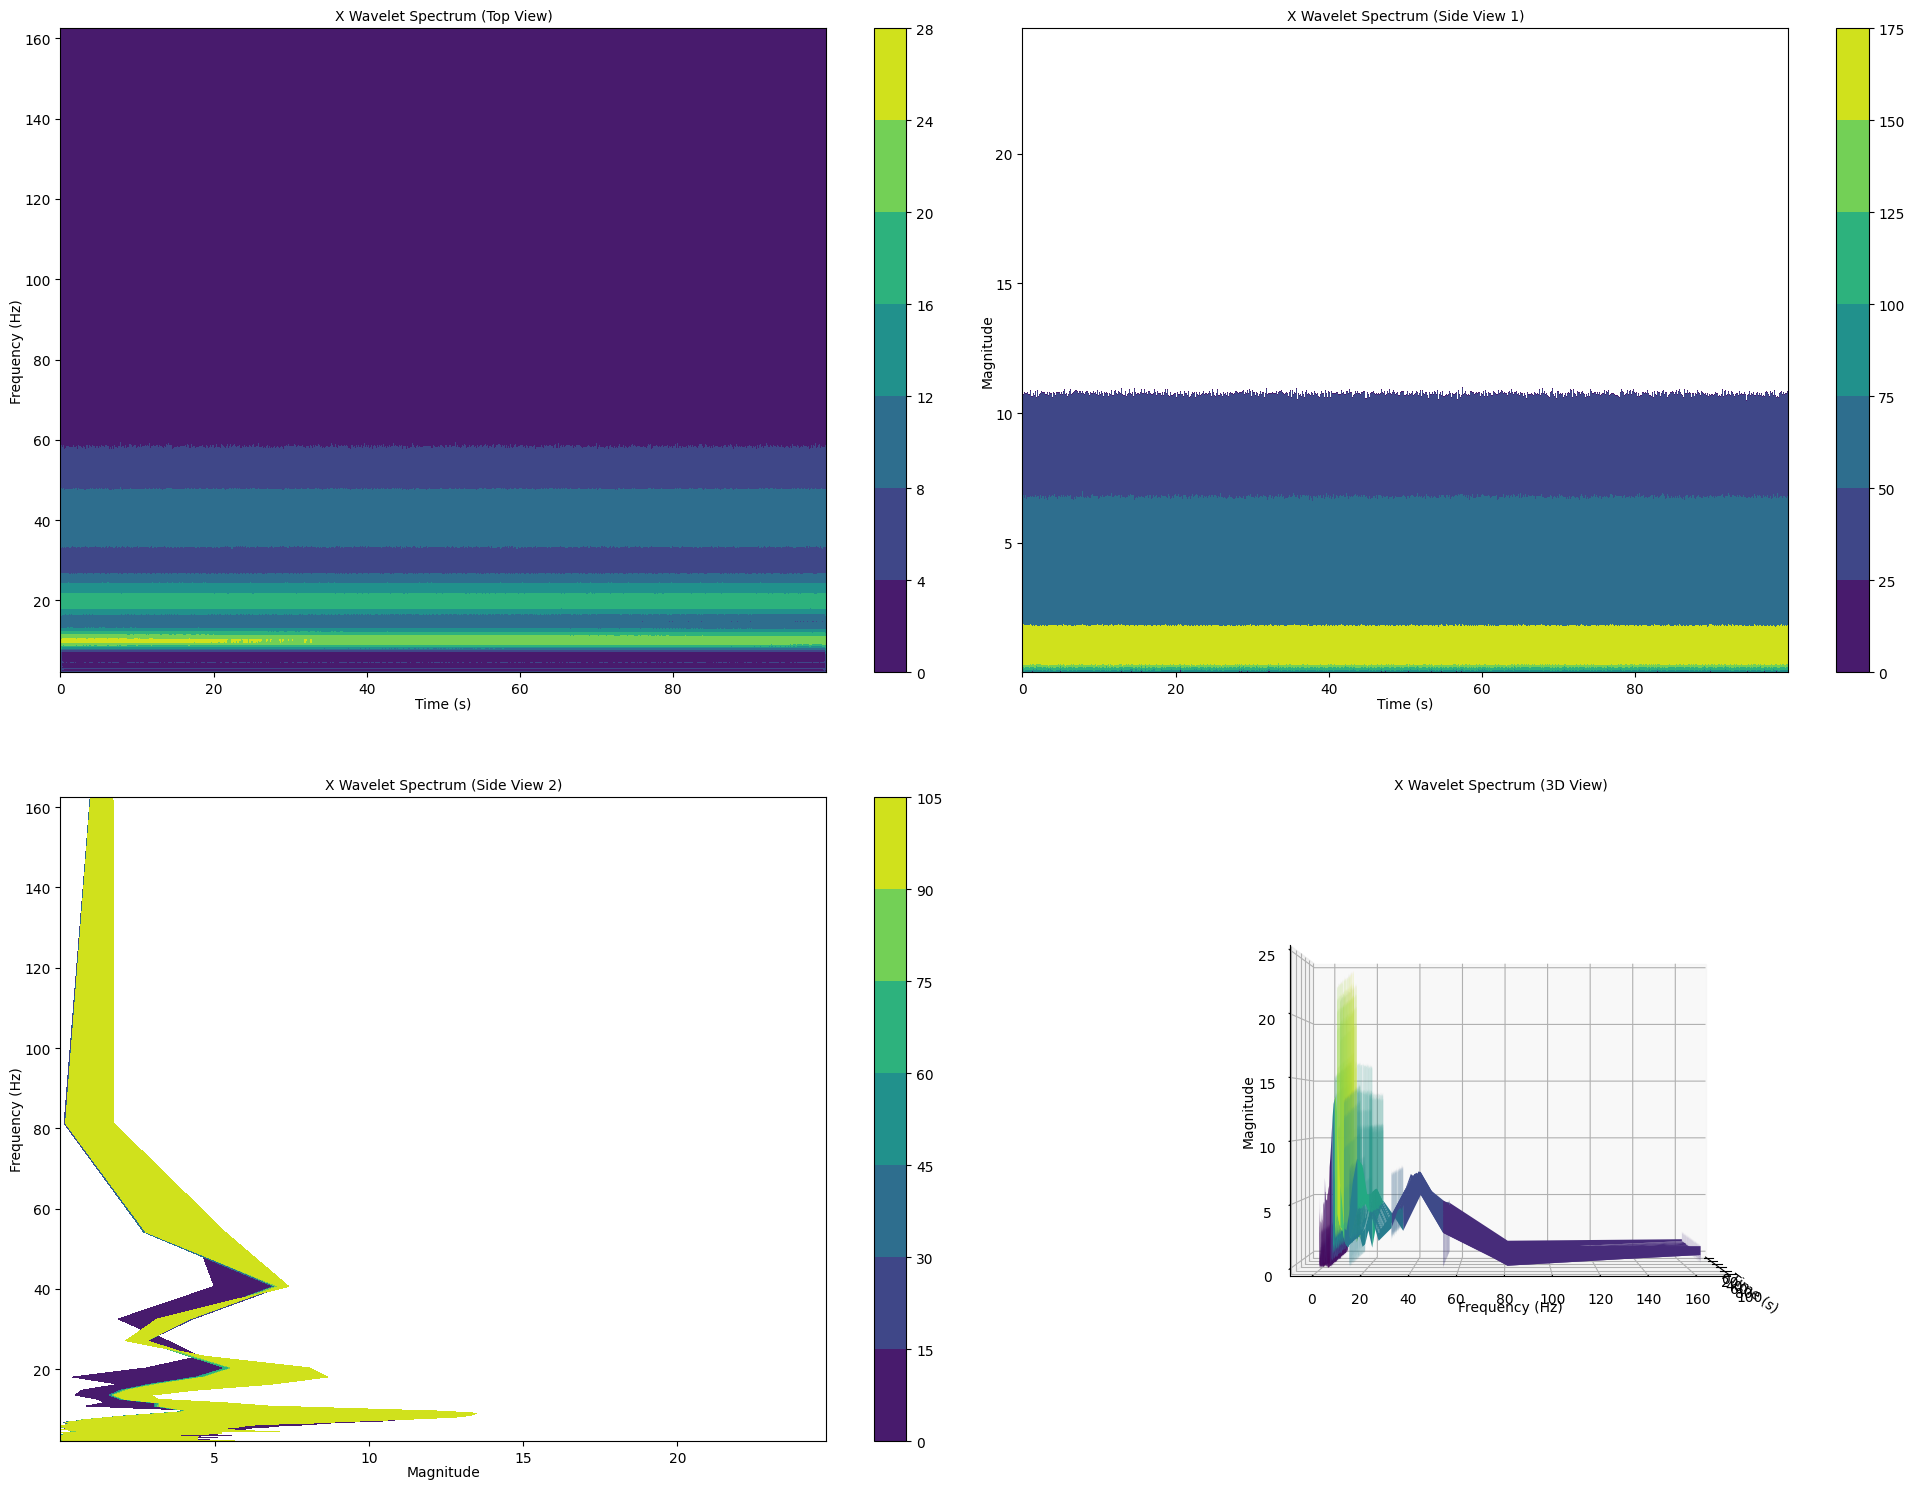

In [ ]:
plot_wavelet_spectra(
    df,
    spectrum,
    frequencies,
    direction
)

In [ ]:
def plot_wavelet_spectra_tf(
    df: pd.DataFrame,
    spectrum: np.ndarray,
    frequencies: np.ndarray,
    direction: str,
    elevation: int = 0,
    rotation: int = 0,
    label_size: int = 10,
    label_offset: float = 0.1,
):
    """
    Plots the time-frequency wavelet spectrum (Top View).

    Args:
        df: DataFrame containing the 'Time' column.
        spectrum: Magnitude spectrum of the CWT coefficients.
        frequencies: Frequencies corresponding to the scales.
        direction: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        elevation: Elevation angle for the 3D plot (default: 0).
        rotation: Rotation angle for the 3D plot (default: 0).
        label_size: Font size for labels (default: 10).
        label_offset: Offset for labels (default: 0.1).

    Returns:
        None (displays the plot).
    """
    time_step = df["Time"].iloc[1] - df["Time"].iloc[0]
    sampling_rate = 1 / time_step
    nyquist_freq = sampling_rate / 2
            
    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), nyquist_freq

    # Filter the range of time and frequency
    mask_x = (df["Time"] >= time_min) & (df["Time"] <= time_max)
    mask_y = (frequencies >= freq_min) & (frequencies <= freq_max)

    time_filtered = df["Time"][mask_x].values
    frequencies_filtered = frequencies[mask_y]
    spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

    # Create the meshgrid for the plot
    X, Y = np.meshgrid(time_filtered, frequencies_filtered)

    # Verify dimensions
    if X.shape != spectrum_filtered.shape:
        print(f"Shape mismatch: X{X.shape}, Y{Y.shape}, Z{spectrum_filtered.shape}")
        return

    # Create the figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)  # Remove projection argument

    # Plotting the contour
    contour = ax.contourf(X, Y, spectrum_filtered, cmap="viridis")
    ax.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax.set_title(f"{direction} Wavelet Spectrum (Top View)", fontsize=label_size)
    fig.colorbar(contour, ax=ax)
    

    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

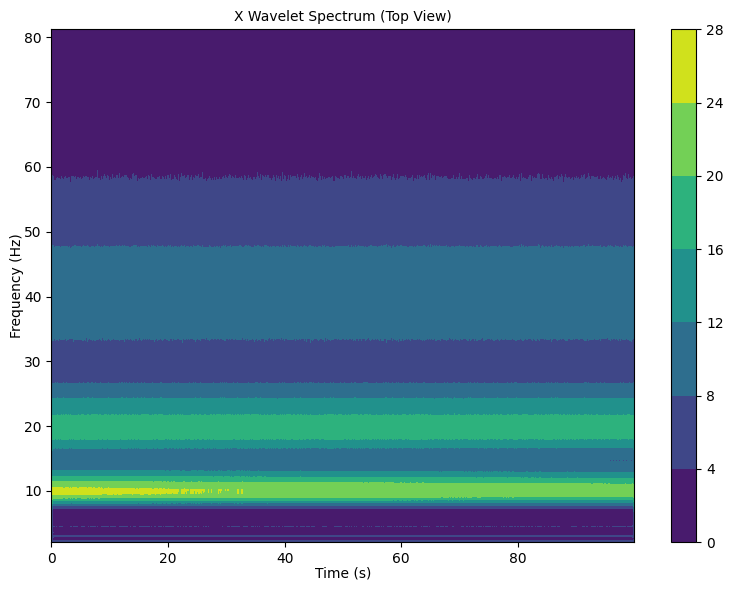

In [ ]:
plot_wavelet_spectra_tf(
    df,
    spectrum,
    frequencies,
    direction
)

In [ ]:
def plot_wavelet_spectra_tm(
    df: pd.DataFrame,
    spectrum: np.ndarray,
    frequencies: np.ndarray,
    direction: str,
    label_size: int = 10,
    label_offset: float = 0.1,
):
    """
    Plots the time-magnitude wavelet spectrum (Side View 1).

    Args:
        df: DataFrame containing the 'Time' column.
        spectrum: Magnitude spectrum of the CWT coefficients.
        frequencies: Frequencies corresponding to the scales.
        direction: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        label_size: Font size for labels (default: 10).
        label_offset: Offset for labels (default: 0.1).

    Returns:
        None (displays the plot).
    """
    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), frequencies.max()

    # Filter the range of time and frequency
    mask_x = (df["Time"] >= time_min) & (df["Time"] <= time_max)
    mask_y = (frequencies >= freq_min) & (frequencies <= freq_max)

    time_filtered = df["Time"][mask_x].values
    frequencies_filtered = frequencies[mask_y]
    spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

    # Create the meshgrid for the plot
    X, Y = np.meshgrid(time_filtered, frequencies_filtered)

    # Verify dimensions
    if X.shape != spectrum_filtered.shape:
        print(f"Shape mismatch: X{X.shape}, Y{Y.shape}, Z{spectrum_filtered.shape}")
        return

    # Create the figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    # Create the Contour plot
    contour = ax.contourf(X, spectrum_filtered, Y, cmap="viridis")

    # Set labels and title
    ax.set_xlabel("Time (s)", fontsize=label_size, labelpad=label_offset)
    ax.set_ylabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax.set_title(f"{direction} Wavelet Spectrum (Side View 1)", fontsize=label_size)

    # Add colorbar
    fig.colorbar(contour, ax=ax)

    plt.tight_layout()
    plt.show()

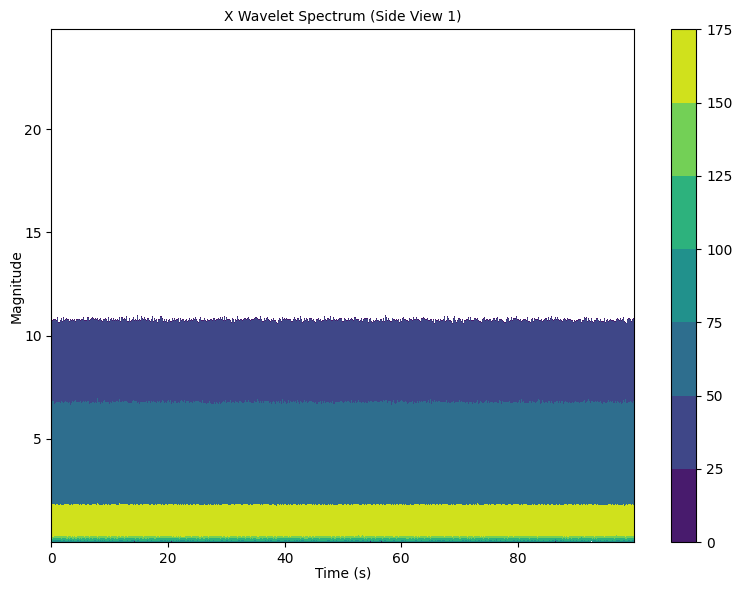

In [ ]:
plot_wavelet_spectra_tm(
    df,
    spectrum,
    frequencies,
    direction
)

In [ ]:
def plot_wavelet_spectra_fm(
    df: pd.DataFrame,
    spectrum: np.ndarray,
    frequencies: np.ndarray,
    direction: str,
    label_size: int = 10,
    label_offset: float = 0.1,
):
    """
    Plots the time-magnitude wavelet spectrum (Side View 1).

    Args:
        df: DataFrame containing the 'Time' column.
        spectrum: Magnitude spectrum of the CWT coefficients.
        frequencies: Frequencies corresponding to the scales.
        direction: Direction of the acceleration data (e.g., 'X', 'Y', 'Z').
        label_size: Font size for labels (default: 10).
        label_offset: Offset for labels (default: 0.1).

    Returns:
        None (displays the plot).
    """
    time_min, time_max = df["Time"].min(), df["Time"].max()
    freq_min, freq_max = frequencies.min(), frequencies.max()

    # Filter the range of time and frequency
    mask_x = (df["Time"] >= time_min) & (df["Time"] <= time_max)
    mask_y = (frequencies >= freq_min) & (frequencies <= freq_max)

    time_filtered = df["Time"][mask_x].values
    frequencies_filtered = frequencies[mask_y]
    spectrum_filtered = spectrum[np.ix_(mask_y, mask_x)]

    # Create the meshgrid for the plot
    X, Y = np.meshgrid(time_filtered, frequencies_filtered)

    # Verify dimensions
    if X.shape != spectrum_filtered.shape:
        print(f"Shape mismatch: X{X.shape}, Y{Y.shape}, Z{spectrum_filtered.shape}")
        return

    # Create the figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    
    c = ax.contourf(spectrum_filtered, Y, X, cmap="viridis")  # Swapped X and spectrum_filtered for side view
    ax.set_xlabel("Magnitude", fontsize=label_size, labelpad=label_offset)
    ax.set_ylabel("Frequency (Hz)", fontsize=label_size, labelpad=label_offset)
    ax.set_title(f"{direction} Wavelet Spectrum (Side View 2)", fontsize=label_size)
    fig.colorbar(c, ax=ax)
    
    plt.tight_layout()
    plt.show()

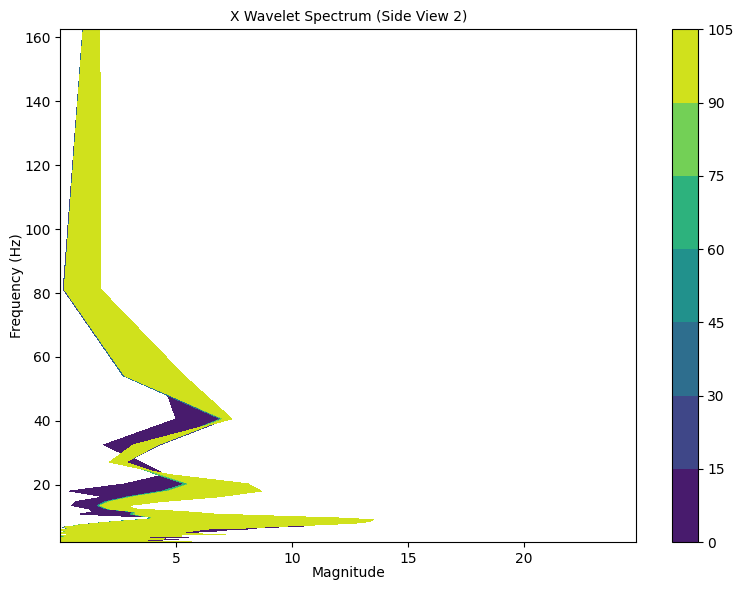

In [ ]:
plot_wavelet_spectra_fm(
    df,
    spectrum,
    frequencies,
    direction
)